# Network filtering and scRNA-seq comparison
This notebook include the analyses described in 3.3.2 Gene-body openness as a filtering criterion for TFs and 3.3.4 Comparison with snucRNA-seq at TFs and TGs level    

In [40]:
# import packages
import os
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
import venn as venn
from statsmodels.stats.multitest import multipletests  

## Preparing for network filtering

### Load TF-motif information

In [41]:
# load a list of known TFs with their family and motif information
base_dir = "/home/claudia/Desktop/UGent/Thesis/" 
tf_file = "TF2fam2mot_n.txt" 

with open(base_dir+'enrichment/'+tf_file) as f:
    lines = f.readlines()         
    tf2mot = {}
    mot2tf = {}
    tf_names = [] # All TFs
    tf_names_Y = [] # TFs with motif info
    for l in lines:
        l = l.split('\t')
        motifs = l[3] 
        tf = l[0]
        tf_names.append(tf)
        if l[2] == 'Y':
            tf_names_Y.append(tf)
            tf2mot[tf] = [ m.strip() for m in motifs.split(',')]
            
            for m in motifs.split(','):
                m = m.strip()
                if m in mot2tf:
                    mot2tf[m].append(tf)
                else:
                    mot2tf[m] = [tf]

print("Root TFs: {}".format(len(tf_names)))
print("Root TFs with motif information: {}".format(len(tf_names_Y)))

Root TFs: 1877
Root TFs with motif information: 1117


### Gold Standard from DE genes

In [42]:
ACR_celltypes = ['Trichoblast', 'Xylem', 'LRC', 'Cortex', 'Epidermis', 'Atrichoblast', 'Pericycle', 'Cambium',  'Endodermis' , 'Phloem'] # Clusters with names

In [43]:
denyer= base_dir+"/GS/denyer_DE.xls"
jeanbaptiste=base_dir+"/GS/jeanbaptiste_de.xls"
wendrich=base_dir+"/GS/wendrich_de.xls"

#### Denyer

In [44]:
de_denyer = pd.read_excel(denyer)
print("columns: {}".format(de_denyer.columns))
print("cell types: {}".format(set(de_denyer.Annotation)))
de_denyer = de_denyer[de_denyer.iloc[:]['qval'] < 0.05]
de_denyer = de_denyer[de_denyer.iloc[:]['avg_logFC'] > 0.25] 
print("genes: {}".format(de_denyer.shape[0]))

columns: Index(['Gene', 'avg_logFC', 'qval', 'Annotation'], dtype='object')
cell types: {'Xylem', 'Cortex', 'Atrichoblast', 'Stele', 'Endodermis', 'Trichoblast'}
genes: 6800


#### jeanbaptiste

In [45]:
de_jeanbaptiste = pd.read_excel(jeanbaptiste) 
print(de_jeanbaptiste.columns)
print(set(de_jeanbaptiste.Annotation))

Index(['Annotation', 'Gene', 'Pct.1', 'qval', 'mean'], dtype='object')
{'nonHair', 'stele', 'endodermis', 'cortex', 'hair'}


In [46]:
de_jeanbaptiste.loc[de_jeanbaptiste.iloc[:]['Annotation'] == 'nonHair', 'Annotation'] = 'Atrichoblast'
de_jeanbaptiste.loc[de_jeanbaptiste.iloc[:]['Annotation'] == 'hair', 'Annotation'] = 'Trichoblast'
de_jeanbaptiste.loc[de_jeanbaptiste.iloc[:]['Annotation'] == 'stele', 'Annotation'] = 'Stele' # do i add a copy of this to xylem and phloem? 
de_jeanbaptiste.loc[de_jeanbaptiste.iloc[:]['Annotation'] == 'cortex', 'Annotation'] = 'Cortex'
de_jeanbaptiste.loc[de_jeanbaptiste.iloc[:]['Annotation'] == 'endodermis', 'Annotation'] = 'Endodermis'

In [47]:
de_jeanbaptiste = de_jeanbaptiste[de_jeanbaptiste.iloc[:]['qval'] < 0.05]
de_jeanbaptiste = de_jeanbaptiste[de_jeanbaptiste.iloc[:]['mean'] > 0.25]  
print(de_jeanbaptiste.shape)

(381, 5)


#### Wendrich

In [48]:
de_wendrich = pd.read_excel(wendrich) 
print(de_wendrich.columns)
print(set(de_wendrich.Annotation))

Index(['Gene', 'avg_logFC', 'Pct.1', 'Pct.2', 'qval', 'Annotation'], dtype='object')
{'Procambium', 'Phloem', 'Cortex', 'Xylem', 'Atrichoblast', 'Epidermis', 'Endodermis', 'Trichoblast', 'LRC', 'Pericycle'}


In [49]:
de_wendrich = de_wendrich[de_wendrich.iloc[:]['avg_logFC'] > 0.25] 
de_wendrich = de_wendrich[de_wendrich.iloc[:]['qval'] < 0.05]

de_wendrich['Gene'] = de_wendrich['Gene'].apply(lambda x: x.split('-')[0])
 
print(de_wendrich.shape)

(10406, 6)


#### All together

In [50]:
de_all = pd.concat([de_wendrich[['Gene','Annotation']],de_denyer[['Gene','Annotation']],de_jeanbaptiste[['Gene','Annotation']]]).drop_duplicates().reset_index(drop=True) 

In [51]:
#retain only TFs with motif information
de_all_tfs = de_all[de_all['Gene'].isin(tf_names_Y)] #do it only fot motif 
print(de_all_tfs.shape)

(708, 2)


In [52]:
de_all_tfs['Annotation'].value_counts()

Stele           94
Procambium      89
Phloem          82
Xylem           78
Pericycle       76
Trichoblast     66
LRC             61
Cortex          58
Endodermis      49
Atrichoblast    33
Epidermis       22
Name: Annotation, dtype: int64

### Read in my cell-type networks

In [53]:
cell_type = 'trichoblast'
capital_cell_type = 'Trichoblast'

In [54]:
# data preparation and p-value adjustment for motif significance
input_file = "/home/claudia/Desktop/UGent/Thesis/networks_second/"+cell_type+"_all_stats.txt"

shuff_stats = pd.read_csv(input_file, sep = "\t", header = None)
shuff_stats.columns = ["PWM", "num_shufflings", "real_ints", "shuff_ints", "p_val", "enrichment_fold"]
wm = lambda x: np.average(x, weights = (shuff_stats.loc[x.index, "num_shufflings"] / 1000))
processed_stats = shuff_stats.groupby('PWM').agg({'num_shufflings' : 'sum',
                                'real_ints': 'max',
                                'shuff_ints': wm,
                                'p_val': wm,
                                'enrichment_fold': wm})

processed_stats.loc[(processed_stats['p_val'] == 0), 'p_val'] = 0.0009
FDR = multipletests(processed_stats['p_val'], method = 'fdr_bh', alpha = 0.01)
processed_stats.insert(4, 'adj_pval', FDR[1])
processed_stats = processed_stats.reset_index()
processed_stats.loc[:, 'PWM'] = processed_stats.loc[:, 'PWM'].str.split("_", expand = True)[0]
processed_stats = processed_stats.set_index('PWM')

# filter significant motif (adjusted p-val < 0.05)
out_motifs = list(processed_stats.loc[(processed_stats['adj_pval'] < 0.05), :].index)
out_motifs = [l + "_network.txt" for l in out_motifs] 
print("Number of motifs: {}".format(len(out_motifs)))

Number of motifs: 785


In [55]:
# load networks of significant motifs
net_dir= base_dir+'networks_second/'+cell_type+'/'
net_files = os.listdir(net_dir) 
miniac_TFs = set() # My mini-ac_TFs 
miniac_TF2TG = dict()

for net in net_files:
    if net in out_motifs:
        with open(net_dir+net) as f:
            lines = f.readlines()
            mot = net.split('_')[0] 
            tgs = set()
            tfs = set()
            for line in lines:
                line = line.split('\t') 
                tgs.add(line[1])
                tfs.add(line[0])
                    
                                           
            for tf in tfs:
                miniac_TFs.add(tf) 
                for tg in tgs:
                    tg = tg.rstrip()
                    if tf in miniac_TF2TG:
                        miniac_TF2TG[tf].add(tg)
                    else:
                        miniac_TF2TG[tf] = {tg}

In [56]:
len(miniac_TFs)

605

In [57]:
mean_tgs = 0
for k in miniac_TF2TG:
    mean_tgs += len(miniac_TF2TG[k])
print(mean_tgs/len(miniac_TF2TG))


390.8066115702479


### Filter MINI-AC TFs based on GS

In [58]:
GS_tfs = de_all_tfs.loc[de_all['Annotation'] == capital_cell_type, 'Gene']

In [59]:
# Check which MINI-AC have a motif in GS
right_side = set(miniac_TFs).difference(GS_tfs) 
GS_AND_MINIAC = set(GS_tfs).intersection(set(miniac_TFs))
to_remove = set()
for fp in right_side:  
    for tf in GS_AND_MINIAC:  
        if tf in tf2mot: # if i don't have motif info is useless to check
            inter = len(set(tf2mot[fp]).intersection(set(tf2mot[tf])))
            if inter != 0: # if their motifs intersect i can consider it a TP 
                to_remove.add(fp)
                break

print("MINI-AC TFs for which their motif has been seen in GS {}".format(len(to_remove)))            
miniac_and_gs_filtered_TFs = GS_AND_MINIAC.union(right_side).difference(to_remove)

MINI-AC TFs for which their motif has been seen in GS 129


MINI-AC in GS: 43


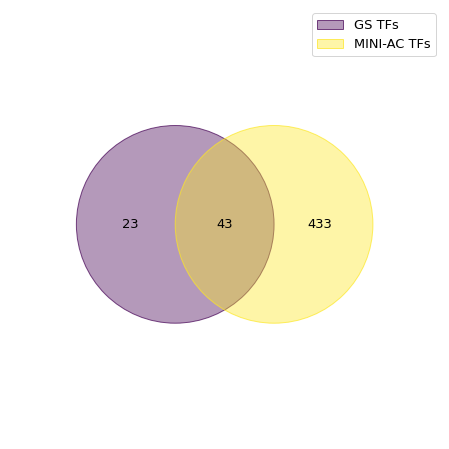

In [60]:
from venn import venn
miniac_gs_venn = {
    "GS TFs": set(GS_tfs),
    "MINI-AC TFs": set(miniac_and_gs_filtered_TFs)
}
venn(miniac_gs_venn)
print("MINI-AC in GS: {}".format(len(set(GS_tfs).intersection(miniac_and_gs_filtered_TFs))))

## Filtering strategy

### Gene-body openness

#### Preparation

In [61]:
# have to use tfs_position_file to extract position of selected miniac_TFs
tfs_position_file = '/home/claudia/Desktop/UGent/Thesis/enrichment/tfs_pos_1kb.csv'
cell_type_position_file="/home/claudia/Desktop/UGent/Thesis/networks_second/sorted_"+cell_type+"_DARs.bed"

# process tfs_position file to save into dict and read just once
tf_dict = {}
with open(tfs_position_file) as h:
    lines = h.readlines()[1:]
    for l in lines:
        l = l.split(',')
        name = l[0]
        pos = "_".join(l[1:])
        pos = pos.rstrip()
        
        if name not in tf_dict:
            tf_dict[name] = [pos]
        else:
            tf_dict[name].append(pos)       

In [62]:
# read in cell_type_pos
cell_type_pos = []
with open(cell_type_position_file) as h:
    lines = h.readlines()[1:]
    for l in lines:
        l = l.split('\t')
        chr_ = l[0][-1]
        start = l[1]
        stop = l[2]
        pos = "_".join([chr_,start,stop])
        pos = pos.rstrip()
        cell_type_pos.append(pos)  

In [63]:
TF_covered = {}
for tf in miniac_TFs:
    e_length = 0    
    overlap_length = 0
    if tf in tf_dict: #bc annotation doesn't have some tf
        for exon in tf_dict[tf]:
            e_chr, e_start, e_stop = exon.split('_')
            e_chr, e_start, e_stop = int(e_chr), int(e_start), int(e_stop)
            e_length += e_stop - e_start + 1
            
            for peak in cell_type_pos:
                p_chr, p_start, p_stop = peak.split('_')
                p_chr, p_start, p_stop = int(p_chr), int(p_start), int(p_stop)

                # same chromosome
                if p_chr == e_chr:
                    # peaks end before exon starts or peaks start after exon has ended, not overlapping
                    if p_stop < e_start or p_start > e_stop: 
                        continue
                    else:
                        if p_start <= e_start:
                            tmp_start = e_start
                        else:
                            tmp_start = p_start

                        if p_stop >= e_stop:
                            tmp_stop = e_stop
                        else:                            
                            tmp_stop = p_stop

                        overlap_length += tmp_stop - tmp_start + 1

        TF_covered[tf] = overlap_length/e_length
    else:
        print(tf, " not in annotation file")


AT2G36011  not in annotation file


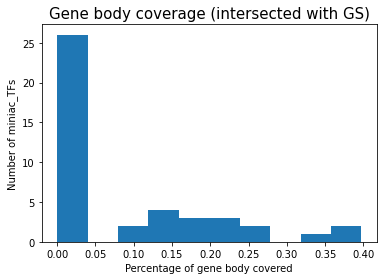

In [64]:
# plot gene-body openness of all GS TFs in the cell-type
ax = plt.subplot()
values_intersect = []
for k,v in list(TF_covered.items()):
    if k in GS_AND_MINIAC:
        values_intersect.append(v)
        
plt.hist(values_intersect, bins=10)
ax.set_title('Gene body coverage (intersected with GS)', size = 15)
ax.set_xlabel('Percentage of gene body covered', size = 10)
ax.set_ylabel('Number of miniac_TFs', size= 10)
plt.show()

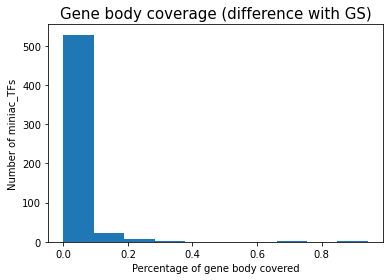

In [65]:
# plot gene-body openness of all non-GS TFs in the cell-type
ax = plt.subplot()
values_right = []
for k,v in list(TF_covered.items()):
    if k in right_side:
        values_right.append(v)
        
plt.hist(values_right, bins=10)
ax.set_title('Gene body coverage (difference with GS)', size = 15)
ax.set_xlabel('Percentage of gene body covered', size = 10)
ax.set_ylabel('Number of miniac_TFs', size= 10)
plt.show()

#### Statistical test

In [66]:
# compute hypergeometric test to detect is gene-body openness is significantly enriched for GS TFs

t_range = [1,5,10,20,30]
thresholds = [t/100 for t in t_range]
p_values = []
f1s = []
print("Thr \t p-value \t f1")
for t in thresholds:
    open_tfs = []
    for k,v in list(TF_covered.items()):
        if v > t:
            open_tfs.append(k)
        
    TP = len(set(GS_AND_MINIAC).intersection(open_tfs))
    FP = len(set(open_tfs).difference(set(GS_AND_MINIAC)))
    FN = len(set(GS_AND_MINIAC).difference(set(open_tfs)))
    F1 = round(TP / (TP + (1/2)*(FP+FN)),3)
    f1s.append(F1) 
    
    M = len(miniac_TFs)  # Total number of MINI-AC TFs
    n = len(GS_AND_MINIAC)  # Number of miniac_TFs which are DE and DAR 
    N = len(open_tfs)   # Number of my open miniac_TFs (if I take N miniac_TFs) 
    k = len(GS_AND_MINIAC.intersection(open_tfs))   # NUmber of intersected miniac_TFs (what is the chance to get k TPs (or more?)) 
    
    hpd = ss.hypergeom(M, n, N)
    p = hpd.pmf(k)
    print(t, "\t" , round(p,8), '\t', F1)
    p_values.append(p)

sig_mask = [i for i,p in enumerate(p_values) if p > .05]
for i in sig_mask:
    f1s[i] = -1

if max(f1s) != -1:
    best_index = np.argmax(f1s)
    print(thresholds[best_index])
else:
    print("NONE SIGNIFICANT")


Thr 	 p-value 	 f1
0.01 	 5e-08 	 0.33
0.05 	 2e-08 	 0.34
0.1 	 0.0 	 0.374
0.2 	 8.12e-06 	 0.262
0.3 	 0.00892709 	 0.12
0.1


Open miniac_TFs  48


<AxesSubplot:>

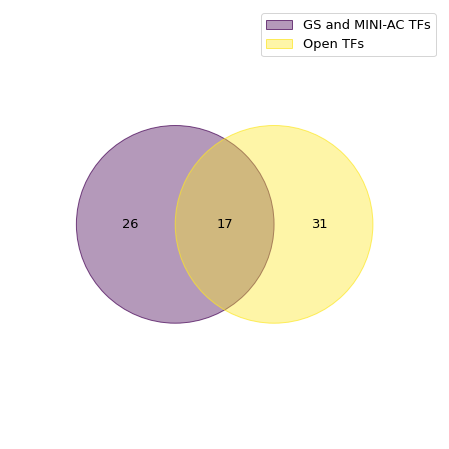

In [67]:
open_tfs = []
for k,v in list(TF_covered.items()):
    if v > thresholds[best_index]:
        open_tfs.append(k)

#print("Openness threshold ", thresholds[best_index])
print("Open miniac_TFs ", len(open_tfs))

miniac_gs_venn = {
    "GS and MINI-AC TFs": set(GS_AND_MINIAC),
    "Open TFs": set(open_tfs),
}
venn(miniac_gs_venn)
#plt.savefig("/home/claudia/Desktop/UGent/Thesis/figures/"+cell_type+".svg")

In [68]:
open_tgs = set()
for k in miniac_TF2TG.keys():
    if k in open_tfs:
        for v in miniac_TF2TG[k]:
            open_tgs.add(v.rstrip())
        

In [69]:
len(open_tgs)

3120

### Expression based

#### Preparation

In [70]:
farmer = pd.read_excel("/home/claudia/Desktop/UGent/Thesis/GS/farmer.xls", index_col = 0)

taus = []
for index, row in farmer.iterrows(): 
    maximum = max(row) 
    transformed_row = [1 - (x/maximum) for x in row]
    taus.append(sum(transformed_row)/len(row))

generic_indexes = []
for i,t in enumerate(taus):
    if t < 0.5: 
        generic_indexes.append(i)

farmer = farmer.drop(index=generic_indexes)
id_max = list(farmer.idxmax(axis=1))


#### Statistical test

0.32225246 0.04
DE miniac_TFs  7


<AxesSubplot:>

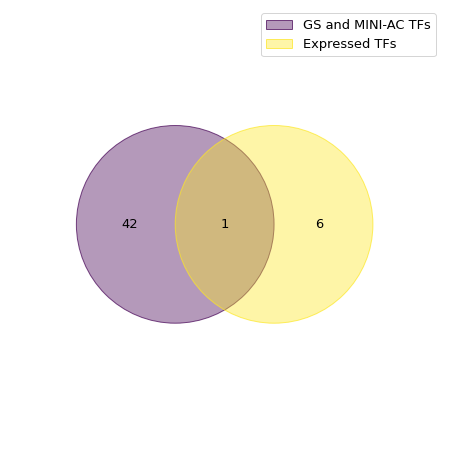

In [71]:
farmer_de = dict()
for i,type in enumerate(id_max):
    k = type.split('.')[0]
    
    if k not in farmer_de:
        farmer_de[k] = set()
    farmer_de[k].add(farmer.index[i])
 

de_tfs = set(miniac_TFs).intersection(set(farmer_de[capital_cell_type])) # Among my Tfs, if I only take the ones that are DE in Farmer
TP = len(set(GS_AND_MINIAC).intersection(de_tfs))
FP = len(set(de_tfs).difference(set(GS_AND_MINIAC)))
FN = len(set(GS_AND_MINIAC).difference(set(de_tfs)))
F1 = round(TP / (TP + (1/2)*(FP+FN)),3)
  
M = len(miniac_TFs)  # Total number of DA
n = len(GS_AND_MINIAC)  # Number of miniac_TFs which are DE and DAR 
N = len(de_tfs)   # Number of my miniac_TFs which are DE (if I take N miniac_TFs) 
k = len(GS_AND_MINIAC.intersection(de_tfs))   # NUmber of intersected miniac_TFs (what is the chance to get k TPs (or more?)) 
    
hpd = ss.hypergeom(M, n, N)
p = hpd.pmf(k)
print(round(p,8), F1) 
 
 
print("DE miniac_TFs ", len(de_tfs))


miniac_gs_venn = {
    "GS and MINI-AC TFs": set(GS_AND_MINIAC),
    "Expressed TFs": set(de_tfs),
}
venn(miniac_gs_venn)

# Snuc-RNA and scATAC comparison 

## TFs

Jaccard:  0.05357142857142857
Intersection:  3


<AxesSubplot:>

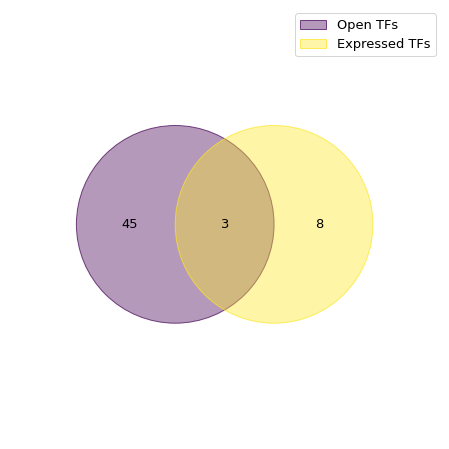

In [72]:
de_tfs = set(farmer_de[capital_cell_type])
de_tfs = set(de_tfs).intersection(set(tf_names_Y))
J = len(set(open_tfs).intersection(de_tfs)) / len(set(open_tfs).union(de_tfs))
print("Jaccard: ", J)
print("Intersection: ",len(set(open_tfs).intersection(de_tfs)))
miniac_gs_venn = {
    "Open TFs": set(open_tfs),
    "Expressed TFs": set(de_tfs),
}
venn(miniac_gs_venn)

## TGs 

Intersection:  224
Jaccard:  0.06888068880688807
Percent:  0.6292134831460674


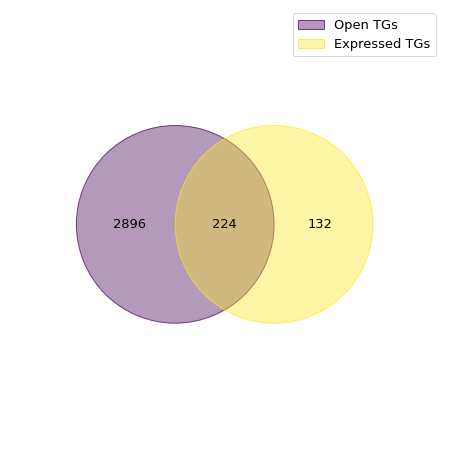

In [73]:
de_tgs = set(farmer_de[capital_cell_type])
print("Intersection: ",len(set(open_tgs).intersection(de_tgs)))
miniac_gs_venn = {
    "Open TGs": set(open_tgs),
    "Expressed TGs": set(de_tgs),
}
venn(miniac_gs_venn)

J = len(set(open_tgs).intersection(de_tgs)) /  len(set(open_tgs).union(de_tgs))
print("Jaccard: ",J)

percent = len(set(open_tgs).intersection(de_tgs)) / len(de_tgs)
print("Percent: ",percent)

## Save regulons

In [74]:
with open("/home/claudia/Desktop/UGent/Thesis/networks_second/regulons/regulons_"+cell_type+".txt", "w") as out:
    for i,tf in enumerate(open_tfs):
        for v in miniac_TF2TG[tf]: 
            out.write(tf+"\t"+v+"\n")